In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [4]:
#from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32
from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32

In [5]:
from scipy.stats import multivariate_normal

In [6]:
import math

In [7]:
import sys, os

In [8]:
import pickle

In [9]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [10]:
from waveimage import calc_U

## Creation de la base d'apprentissage

In [12]:
file_name = "mnist-waveimage-train-mu-Sigma-rho-naive.pkl"
if True : #not os.path.isfile(file_name):
    
    B_train = []
    for i in range(len(mnist.train.images)):
        if i % 1000 == 0 :
            sys.stdout.write('\rstep %d' % i) 
            sys.stdout.flush()
        c = mnist.train.labels[i]
        x_ref = mnist.train.images[i]
        '''m_x = np.mean(x_ref)
        #print test
        x_noise = x_ref * (1 - 0.3)  + (0.3) * (1 - x_ref)
        x_noise = x_noise * np.random.rand(28 * 28) * np.random.binomial(1, x_noise)'''
        '''x_noise = np.copy(x_ref)
        for _ in range(100):
            i_1 = np.where(np.random.multinomial(1, np.ones(784)/784) == 1)[0][0]
            i_2 = np.where(np.random.multinomial(1, np.ones(784)/784) == 1)[0][0]
            x_noise[i_1], x_noise[i_2] = x_noise[i_2], x_noise[i_1]'''
        image = mnist_reshape_32(x_ref)
        w = WaveImage(image = image)
        data = w.get_data()
        for h in range(w.get_h_max()):
            data_h = w.get_data()[h]
            for u in data_h:
                v = data_h[u]
                B_train += [(v,(c,h,u))]   
                
    ### Dictionnaire (Base d'apprentissage)    
    
    Data_train = [[],[],[],[],[],[],[],[],[],[]]
    for c in range(10):
        Data_train[c] = [{},{},{},{},{},{}] 

    for d in B_train:
        v = d[0]
        c = d[1][0]
        h = d[1][1]
        u = d[1][2]
        if u in Data_train[c][h]:
            Data_train[c][h][u] += [v]
        else:
            Data_train[c][h][u] = [v]
            
    ### Probas elementaires         
    mu = []
    Sigma = []
    rho = []
    for c in range(10):
        mu += [{}]
        Sigma += [{}]
        rho += [{}]
        for h in range(0,6):
            mu[c][h] = {}
            Sigma[c][h] = {}
            rho[c][h] = {}
            for u in calc_U((32, 32), h, 6):
                if u in Data_train[c][h]:
                    data = []
                    cpt = 0
                    for v in Data_train[c][h][u]:
                        if False : #!!!!! Naive model #np.linalg.norm(v) < 1e-16:
                            cpt += 1
                        else:
                            data += [v]
                    #if h == -1 :
                    #    print len(data)
                    if len(data) > 1:
                        mu[c][h][u] = np.mean(data, 0) #Data[c][h][u],0)
                        Sigma[c][h][u] = np.cov(np.array(data).T) #Data[c][h][u]).T)
                        rho[c][h][u] = float(cpt) / len(Data_train[c][h][u])
                    else:
                        mu[c][h][u] = np.zeros(3)
                        Sigma[c][h][u] = np.zeros((3,3))
                        rho[c][h][u] = 1.
    del B_train, Data_train 
    pickle.dump((mu, Sigma, rho),  open(file_name, "wb"))
else:
    mu, Sigma, rho = pickle.load(open(file_name, "rb"))

step 54000

#### Liste des coordonnées par niveau : U[h], h $\in$ 0..5

In [11]:
axes = []
h_max = 6
shape = (32,32)

U = {}
for h in range(h_max):
    #U_ref = {}
    #for pos_i in axes[h]:
    #    for pos_j in axes[h]:
    #        U_ref[h] += [(pos_i, pos_j)]
    U [h] = {}
    dim_i, dim_j = calc_dim(shape, h, h_max)
    for i in range(dim_i):
        for j in range(dim_j):
            U[h][(i,j)] = 1    
    print 'Niveau ', h, ' : '
    print ' U[' , h, '] :', U[h]
    #print ' U_ref[h] :', U_ref[h]
    print ''
    


Niveau  0  : 
 U[ 0 ] : {(0, 0): 1}

Niveau  1  : 
 U[ 1 ] : {(0, 0): 1}

Niveau  2  : 
 U[ 2 ] : {(0, 1): 1, (1, 0): 1, (0, 0): 1, (1, 1): 1}

Niveau  3  : 
 U[ 3 ] : {(0, 1): 1, (1, 2): 1, (3, 2): 1, (0, 0): 1, (3, 3): 1, (3, 0): 1, (3, 1): 1, (2, 1): 1, (0, 2): 1, (2, 0): 1, (1, 3): 1, (2, 3): 1, (2, 2): 1, (1, 0): 1, (0, 3): 1, (1, 1): 1}

Niveau  4  : 
 U[ 4 ] : {(7, 3): 1, (4, 7): 1, (1, 3): 1, (6, 4): 1, (3, 0): 1, (5, 4): 1, (0, 7): 1, (5, 6): 1, (2, 6): 1, (1, 6): 1, (5, 1): 1, (3, 7): 1, (2, 5): 1, (0, 3): 1, (7, 2): 1, (4, 0): 1, (1, 2): 1, (6, 7): 1, (3, 3): 1, (2, 0): 1, (7, 6): 1, (4, 4): 1, (6, 3): 1, (1, 5): 1, (3, 6): 1, (2, 2): 1, (7, 7): 1, (5, 7): 1, (5, 3): 1, (4, 1): 1, (1, 1): 1, (2, 7): 1, (3, 2): 1, (0, 0): 1, (6, 6): 1, (5, 0): 1, (7, 1): 1, (4, 5): 1, (0, 4): 1, (5, 5): 1, (1, 4): 1, (6, 0): 1, (7, 5): 1, (2, 3): 1, (2, 1): 1, (4, 2): 1, (1, 0): 1, (6, 5): 1, (3, 5): 1, (0, 1): 1, (7, 0): 1, (4, 6): 1, (5, 2): 1, (6, 1): 1, (3, 1): 1, (0, 2): 1, (7, 4): 1, (0

#### Construction d'un arbre de coordonnées multi-niveau (descendants pour (i,j) au niveau h)

In [12]:
def fils_rec(shape, h, h_max, i, j):
    
    if h < h_max :
        dim_i, dim_j = calc_dim(shape, h, h_max)
        if i < dim_i and j < dim_j :
            rep = [(h,(i,j)), [], [], [], []]
            rep[1] = fils_rec(shape, h + 1, h_max, i * 2, j * 2)
            rep[2] = fils_rec(shape, h + 1, h_max, i * 2, j * 2 + 1)
            rep[3] = fils_rec(shape, h + 1, h_max, i * 2 + 1, j * 2)
            rep[4] = fils_rec(shape, h + 1, h_max, i * 2 + 1, j * 2 + 1)
        else:
            rep = []
    else:
        rep = []
    return rep
    


In [13]:
U_tree = fils_rec(shape, 0, h_max, 0, 0) 
print U_tree

[(0, (0, 0)), [(1, (0, 0)), [(2, (0, 0)), [(3, (0, 0)), [(4, (0, 0)), [(5, (0, 0)), [], [], [], []], [(5, (0, 1)), [], [], [], []], [(5, (1, 0)), [], [], [], []], [(5, (1, 1)), [], [], [], []]], [(4, (0, 1)), [(5, (0, 2)), [], [], [], []], [(5, (0, 3)), [], [], [], []], [(5, (1, 2)), [], [], [], []], [(5, (1, 3)), [], [], [], []]], [(4, (1, 0)), [(5, (2, 0)), [], [], [], []], [(5, (2, 1)), [], [], [], []], [(5, (3, 0)), [], [], [], []], [(5, (3, 1)), [], [], [], []]], [(4, (1, 1)), [(5, (2, 2)), [], [], [], []], [(5, (2, 3)), [], [], [], []], [(5, (3, 2)), [], [], [], []], [(5, (3, 3)), [], [], [], []]]], [(3, (0, 1)), [(4, (0, 2)), [(5, (0, 4)), [], [], [], []], [(5, (0, 5)), [], [], [], []], [(5, (1, 4)), [], [], [], []], [(5, (1, 5)), [], [], [], []]], [(4, (0, 3)), [(5, (0, 6)), [], [], [], []], [(5, (0, 7)), [], [], [], []], [(5, (1, 6)), [], [], [], []], [(5, (1, 7)), [], [], [], []]], [(4, (1, 2)), [(5, (2, 4)), [], [], [], []], [(5, (2, 5)), [], [], [], []], [(5, (3, 4)), [], [

#### Calcul des descendants et des parents

In [14]:
def calcule_desc(U_tree, mem_h_u_todo):
    if U_tree == []:
        return []
    else :
        if U_tree[0] in mem_h_u_todo :
            rep = [U_tree[0]]
        else:
            rep = []
        if U_tree[1] != [] :
            rep += calcule_desc(U_tree[1], mem_h_u_todo)
        if U_tree[2] != [] :
            rep += calcule_desc(U_tree[2], mem_h_u_todo)
        if U_tree[3] != [] :
            rep += calcule_desc(U_tree[3], mem_h_u_todo)
        if U_tree[4] != [] :
            rep += calcule_desc(U_tree[4], mem_h_u_todo)    
        return rep

In [15]:
print calcule_desc(U_tree, [(5, (5, 7)), (4, (2, 3))])

[(4, (2, 3)), (5, (5, 7))]


In [16]:
def find_desc (U_tree, (h, u)):
    if U_tree == []:
        return None
    else :    
        if U_tree[0] == (h, u) :
            return U_tree
        else:
            desc_1 = find_desc(U_tree[1], (h, u))
            if desc_1 != None:
                return desc_1
            desc_2 = find_desc(U_tree[2], (h, u))
            if desc_2 != None:
                return desc_2
            desc_3 = find_desc(U_tree[3], (h, u))
            if desc_3 != None:
                return desc_3
            desc_4 = find_desc(U_tree[4], (h, u))
            if desc_4 != None:
                return desc_4

In [17]:
print find_desc(U_tree, (4, (2, 3)))

[(4, (2, 3)), [(5, (4, 6)), [], [], [], []], [(5, (4, 7)), [], [], [], []], [(5, (5, 6)), [], [], [], []], [(5, (5, 7)), [], [], [], []]]


In [18]:
def calcule_asc_path(h,u):
    rep = []
    for h_inf in range(h, 0, -1):
        i_inf = u[0] / (2 ** (h - h_inf))
        j_inf = u[1] / (2 ** (h - h_inf))
        rep += [(h_inf, (i_inf, j_inf))]
    # racine
    rep += [(0, (i_inf, j_inf))]
    return rep

In [19]:
print calcule_asc_path(5,(15,3))

[(5, (15, 3)), (4, (7, 1)), (3, (3, 0)), (2, (1, 0)), (1, (0, 0)), (0, (0, 0))]


#### Etapes de calcul du posterior : likelihood - log-score - posterior

In [20]:
# Likelihood calculation (over z's, for given v, h and u)

def calc_lik(v,h,u):
    lik = np.zeros(10)
    for c in range(10):
        if np.linalg.norm(v) < 1e-16:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                lik[c] = rho[c][h][u]
            else:
                lik[c] = 1                
        else:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                if h == 0:
                    dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u])
                else:
                    dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u] + 1e-10 * np.eye(3))
                lik[c] = (1-rho[c][h][u]) * dist.pdf(v)
                #lik[c] =  dist.pdf(v)
            else:
                lik[c] = 0
        lik[c] = max(lik[c],1e-16)    
    return lik

In [21]:
# Log posterior

def update_log_score(log_score, lik):
    #print 'lik =' + str(lik) 
    log_score += np.log(lik) 
    max_log_score = max(log_score)
    log_score -= max_log_score
    return log_score

In [22]:
# Posterior (Softmax)
    
def calc_pi(log_score): # TODO
    Z = np.sum(np.exp(log_score))
    pi = np.exp(log_score)/Z
    #print 'pi =' + str(pi)
    #print 'max(pi) = ',max(pi)
    return pi

#### Métriques

In [23]:
# Entropy (over counterfactual viewpoint (h_plus, u_plus))

def calc_H_plus(log_score, v_plus, h_plus, u_plus):
    lik_plus = calc_lik(v_plus, h_plus, u_plus)
    log_score_plus = update_log_score(np.copy(log_score), lik_plus)
    pi_plus = calc_pi(log_score_plus)
    sum_H = - pi_plus * np.log(pi_plus)
    #print 'sum_H : ', sum_H
    #print np.log(lik)
    #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
    #print '**** H = ',
    return sum_H.sum()


In [24]:
# Free Energy (over counterfactual viewpoint (h_plus, u_plus))

def calc_F_plus(pi, log_score, v_plus, h_plus, u_plus):    
    lik_plus = calc_lik(v_plus, h_plus, u_plus)
    log_score_plus = update_log_score(np.copy(log_score), lik_plus)
    pi_plus = calc_pi(log_score_plus)
    sum_F = - pi_plus * (np.log(lik_plus) - np.log(pi_plus) + np.log(pi))
    #print 'sum_F : ', sum_F
    #print np.log(lik)
    #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
    #print '**** H = ',
    return sum_F.sum()   


In [25]:
def calc_IB_plus(pi, log_score, v_plus, h_plus, u_plus):    
    lik_plus = calc_lik(v_plus, h_plus, u_plus)
    log_score_plus = update_log_score(np.copy(log_score), lik_plus)
    pi_plus = calc_pi(log_score_plus)
    sum_IB = pi_plus * (np.log(pi_plus) - np.log(pi))
    #print 'sum_F : ', sum_F
    #print np.log(lik)
    #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
    #print '**** H = ',
    return sum_IB.sum()   


In [26]:
# Gibbs Energy

def calc_E_plus(pi, v_plus, h_plus, u_plus):    
    lik_plus = calc_lik(v_plus, h_plus, u_plus)
    sum_E = pi * lik_plus
    #print 'sum_F : ', sum_F
    #print np.log(lik)
    #print '****', 'c :', c_ref, ', h :', h, ', u :',u, ' ---> ', np.where(pi == max(pi))[0][0]
    #print '**** H = ',
    return sum_E.sum()   

#### Generators

In [27]:
def argmax_generator(c, h, u):
    test_pred = rho[c][h][u] < .5       
    if test_pred:
        return mu[c][h][u]
        #v_predictive = np.random.multivariate_normal(mu[c_predictive][h_path][u_path], Sigma[c_predictive][h_path][u_path], 1)[0]
    else:
        return np.zeros(3)

In [28]:
def monte_carlo_generator(c, h, u):
    if np.random.random() > rho[c][h][u]:
        return np.random.multivariate_normal(mu[c][h][u], Sigma[c][h][u], 1)[0]
    else:
        return np.zeros(3)

#### Likelihood map : `lik_predictive[c][h][u]`

In [30]:
h_max = 6
lik_predictive = {}
for c in range(10):
    lik_predictive[c] = {}
    for h in range(h_max):
        lik_predictive[c][h] = {}
        for u in U[h]:
            log_score = np.zeros(10)
            v_predictive = argmax_generator(c, h, u)
            lik = calc_lik(v_predictive, h, u)
            lik_predictive[c][h][u] = lik

#### Effective saliency map : `pi_predictive_eff[c][u]` (h = 5) 

In [32]:
if not os.path.isfile("mnist-waveimage-saliency-map.pkl"):
    h = h_max - 1
    pi_predictive_eff = {}
    for c in range(10):
        print c
        pi_predictive_eff[c] = {}

        mem_h_u = []
        mem_h_u_todo = {}
        for u_add in U[h]:
            mem_h_u_todo[(5, u_add)] = 1

        while len(mem_h_u_todo) > 0 :    
            pi_predictive_plus = {}
            for (h, u) in mem_h_u_todo:
                liste_path = calcule_asc_path(h, u)
                log_score_path = np.zeros(10)
                for (h_path, u_path) in liste_path[:-1]:
                    if (h_path, u_path) not in mem_h_u:
                        log_score_path = update_log_score(log_score_path, lik_predictive[c][h_path][u_path])
                pi_path = calc_pi(log_score_path)
                #print pi_path
                pi_predictive_plus[u] = pi_path[c] 
                #print h_plus, u_plus
            keys = pi_predictive_plus.keys()
            values = np.array(pi_predictive_plus.values())
            k = np.argmax(values)
            u_tilde = keys[k]
            #print len(pi_predictive_plus), len(mem_h_u), (values[k], (h, u))

            pi_predictive_eff[c][u_tilde] = values[k]
            mem_h_u_todo.pop((h, u_tilde)) 
            liste_path = calcule_asc_path(h, u_tilde)
            log_score_path = np.zeros(10)
            for (h_path, u_path) in liste_path[:-1]:
                if (h_path, u_path) not in mem_h_u:
                    mem_h_u += [(h_path, u_path)]       
    pickle.dump(pi_predictive_eff,  open("mnist-waveimage-saliency-map.pkl", "wb"))
else:
    pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map.pkl", "rb"))            
        #print 'CHOIX :', (h, u)
        
        
        

0
1
2
3
4
5
6
7
8
9


#### Generic saliency map : `H_generic_eff[c][u]` (h = 5) 

In [31]:
from scipy.stats import entropy

In [34]:
if not os.path.isfile("mnist-waveimage-generic-saliency-map.pkl"):
    h = h_max - 1
    H_generic_eff = {}

    mem_h_u = []
    mem_h_u_todo = {}
    for u_add in U[h]:
        mem_h_u_todo[(5, u_add)] = 1
    cpt = 0
    while len(mem_h_u_todo) > 0 :    
        cpt += 1
        H_predictive_plus = {}
        for (h, u) in mem_h_u_todo:
            H_predictive_plus[u] = 0
        for (h, u) in mem_h_u_todo:
            liste_path = calcule_asc_path(h, u)
            for c in range(10):
                log_score_path = np.zeros(10)
                for (h_path, u_path) in liste_path[:-1]:
                    if (h_path, u_path) not in mem_h_u:
                        log_score_path = update_log_score(log_score_path, lik_predictive[c][h_path][u_path])
                pi_path = calc_pi(log_score_path)
                H_c = entropy(pi_path)
                H_predictive_plus[u] += .1 * H_c
        keys = H_predictive_plus.keys()
        values = np.array(H_predictive_plus.values())
        k = np.argmin(values)
        u_tilde = keys[k]
        print(cpt, u_tilde)
        H_generic_eff[u_tilde] = values[k]
        mem_h_u_todo.pop((h, u_tilde)) 
        liste_path = calcule_asc_path(h, u_tilde)
        for (h_path, u_path) in liste_path[:-1]:
            if (h_path, u_path) not in mem_h_u:
                mem_h_u += [(h_path, u_path)]       
    pickle.dump(H_generic_eff,  open("mnist-waveimage-generic-saliency-map.pkl", "wb"))
else:
    H_generic_eff = pickle.load(open("mnist-waveimage-generic-saliency-map.pkl", "rb"))            
        #print 'CHOIX :', (h, u)
        
        
        

(1, (7, 8))
(2, (8, 6))
(3, (3, 9))
(4, (3, 7))
(5, (8, 8))
(6, (13, 7))
(7, (12, 9))
(8, (6, 7))
(9, (7, 10))
(10, (11, 6))
(11, (12, 5))
(12, (8, 10))
(13, (4, 7))
(14, (11, 5))
(15, (3, 10))
(16, (9, 5))
(17, (4, 12))
(18, (7, 5))
(19, (10, 8))
(20, (8, 12))
(21, (11, 10))
(22, (4, 8))
(23, (5, 10))
(24, (5, 5))
(25, (8, 7))
(26, (11, 3))
(27, (6, 12))
(28, (7, 7))
(29, (3, 8))
(30, (9, 7))
(31, (7, 6))
(32, (7, 9))
(33, (8, 5))
(34, (6, 9))
(35, (9, 8))
(36, (11, 4))
(37, (6, 5))
(38, (9, 6))
(39, (6, 6))
(40, (10, 5))
(41, (12, 10))
(42, (9, 10))
(43, (11, 7))
(44, (10, 6))
(45, (10, 11))
(46, (6, 8))
(47, (9, 3))
(48, (10, 10))
(49, (13, 8))
(50, (12, 4))
(51, (12, 6))
(52, (5, 6))
(53, (9, 4))
(54, (10, 7))
(55, (7, 4))
(56, (4, 9))
(57, (9, 11))
(58, (5, 8))
(59, (6, 10))
(60, (4, 6))
(61, (8, 11))
(62, (5, 11))
(63, (8, 4))
(64, (8, 9))
(65, (6, 11))
(66, (13, 6))
(67, (2, 9))
(68, (3, 6))
(69, (5, 7))
(70, (10, 4))
(71, (10, 9))
(72, (5, 9))
(73, (12, 7))
(74, (9, 9))
(75, (4

In [59]:
## test 
h = h_max - 1
H_generic = {}

mem_h_u = []
mem_h_u_todo = {}
for u_add in U[h]:
    mem_h_u_todo[(5, u_add)] = 1
cpt = 0
while len(mem_h_u_todo) > 0 :    
    cpt += 1
    H_predictive_plus = {}
    for (h, u) in mem_h_u_todo:
        H_predictive_plus[u] = 0
    for (h, u) in mem_h_u_todo:
        liste_path = calcule_asc_path(h, u)
        for c in range(10):
            log_score_path = np.zeros(10)
            for (h_path, u_path) in liste_path[:-1]:
                if (h_path, u_path) not in mem_h_u:
                    log_score_path = update_log_score(log_score_path, lik_predictive[c][h_path][u_path])
            pi_path = calc_pi(log_score_path)
            H_c = entropy(pi_path)
            H_predictive_plus[u] += .1 * H_c
    keys = H_predictive_plus.keys()
    values = np.array(H_predictive_plus.values())
    k = np.argmin(values)
    u_tilde = keys[k]
    print(cpt, u_tilde)
    H_generic[u_tilde] = values[k]
    mem_h_u_todo.pop((h, u_tilde)) 

        

(1, (7, 8))
(2, (6, 9))
(3, (6, 8))
(4, (7, 9))
(5, (8, 6))
(6, (9, 6))
(7, (8, 7))
(8, (9, 7))
(9, (3, 10))
(10, (10, 7))
(11, (11, 7))
(12, (11, 6))
(13, (4, 8))
(14, (7, 10))
(15, (3, 11))
(16, (5, 8))
(17, (10, 6))
(18, (8, 5))
(19, (2, 11))
(20, (5, 9))
(21, (2, 10))
(22, (3, 9))
(23, (4, 9))
(24, (3, 8))
(25, (9, 5))
(26, (5, 10))
(27, (5, 11))
(28, (2, 9))
(29, (4, 10))
(30, (2, 8))
(31, (11, 5))
(32, (11, 4))
(33, (6, 10))
(34, (4, 11))
(35, (9, 4))
(36, (6, 11))
(37, (12, 4))
(38, (8, 4))
(39, (12, 5))
(40, (0, 10))
(41, (0, 11))
(42, (1, 11))
(43, (1, 10))
(44, (0, 8))
(45, (0, 9))
(46, (1, 9))
(47, (1, 8))
(48, (7, 11))
(49, (10, 5))
(50, (13, 5))
(51, (12, 6))
(52, (13, 4))
(53, (10, 4))
(54, (12, 7))
(55, (7, 7))
(56, (7, 6))
(57, (13, 6))
(58, (6, 7))
(59, (13, 7))
(60, (15, 4))
(61, (15, 5))
(62, (14, 4))
(63, (14, 5))
(64, (15, 7))
(65, (15, 6))
(66, (14, 6))
(67, (14, 7))
(68, (6, 6))
(69, (7, 4))
(70, (8, 8))
(71, (4, 7))
(72, (7, 5))
(73, (9, 8))
(74, (3, 7))
(75, (6

In [36]:
H_generic_eff

{(0, 0): 23.025850929940457,
 (0, 1): 23.025850929940457,
 (0, 2): 23.025850929940457,
 (0, 3): 23.025850929940457,
 (0, 4): 23.025850929940457,
 (0, 5): 23.025850929940457,
 (0, 6): 23.025850929940457,
 (0, 7): 23.025850929940457,
 (0, 8): 23.025850929940457,
 (0, 9): 23.025850929940457,
 (0, 10): 23.025850929940457,
 (0, 11): 23.025850929940457,
 (0, 12): 23.025850929940457,
 (0, 13): 23.025850929940457,
 (0, 14): 23.025850929940457,
 (0, 15): 23.025850929940457,
 (1, 0): 23.025850929940457,
 (1, 1): 23.025850929940457,
 (1, 2): 23.025850929940457,
 (1, 3): 23.025850684580259,
 (1, 4): 23.025849086622259,
 (1, 5): 23.025784962327766,
 (1, 6): 23.025784479978725,
 (1, 7): 23.025176472993639,
 (1, 8): 23.025235111231694,
 (1, 9): 23.025767847342763,
 (1, 10): 23.025689476541942,
 (1, 11): 23.025845384787051,
 (1, 12): 23.025849948523888,
 (1, 13): 23.025850929940457,
 (1, 14): 23.025850929940457,
 (1, 15): 23.025850929940457,
 (2, 0): 23.025850929940457,
 (2, 1): 23.025850929940457,
 (

### Reconstruction

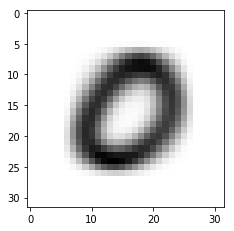

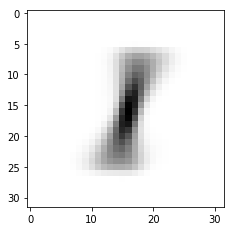

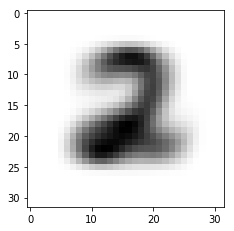

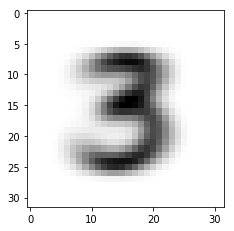

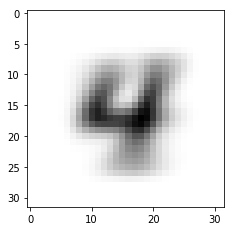

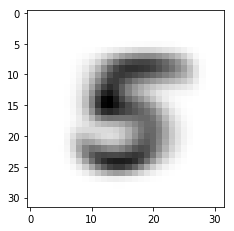

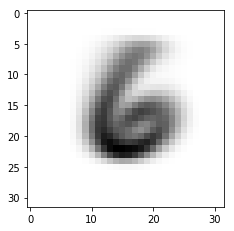

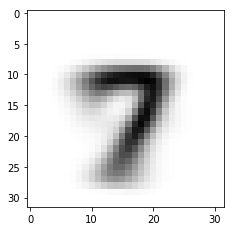

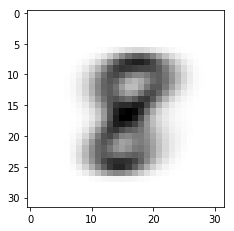

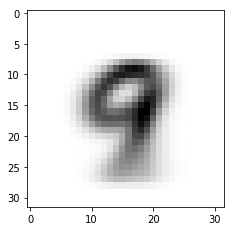

In [37]:
avg_image = {}
for c in range(10):
    w = WaveImage()
    for h in range(6):
        for u in calc_U((32, 32), h, 6):
            w.set_data( h, u, mu[c][h][u] * (1 - rho[c][h][u]))
    avg_image[c] = w.get_image()
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.imshow(w.get_image(), interpolation='nearest', cmap='gray_r')



In [38]:
def calc_pi_predictive_sorted(pi_predictive): 
    pi_predictive_sorted = {}
    for c in range(10):
        pi_predictive_sorted[c] = []
        for k in pi_predictive[c]:
            pi_predictive_sorted[c] += [(pi_predictive[c][k], k)]
        pi_predictive_sorted[c] = sorted(pi_predictive_sorted[c])
    return pi_predictive_sorted

In [54]:
def calc_H_predictive_sorted(H_predictive): 
    H_predictive_sorted = []
    for k in H_predictive:
        H_predictive_sorted += [(H_predictive[k], k)]
    H_predictive_sorted = sorted(H_predictive_sorted, reverse=True)
    return H_predictive_sorted

In [39]:
def affiche_path_mnist(path_i, path_j):
    col_max = max(15, len(path_i))
    colors = plt.cm.rainbow(np.linspace(0, 1, col_max))
    b_moins = -.5
    b_plus = 31.5
    for cpt in range(len(path_i) - 1):
        plt.plot(path_j[cpt:cpt + 2],path_i[cpt:cpt + 2], color = colors[col_max - cpt - 1], linewidth= 3)
    #plt.plot(path_j,path_i,'r+',markersize=12)
    plt.xlim([b_moins,b_plus])
    plt.ylim([b_moins,b_plus])
    plt.gca().invert_yaxis()

In [40]:
def affiche_path(pi_predictive): 
    pi_predictive_sorted = calc_pi_predictive_sorted(pi_predictive)
    for c in range(10):
        image_moy = avg_image[c] #np.mean(np.array(data_visu[c]),0)
        plt.figure(figsize=(12,8))
        plt.subplot(131)
        plt.imshow(image_moy, interpolation='nearest', cmap='gray_r')
        plt.title(c)
        path_i = []
        path_j = []
        image_pi = np.zeros((14,14))
        for cpt in range(6):
            (pi_pred, u) = pi_predictive_sorted[c][-1-cpt]
            #(pi_pred,(h,u)) = pi_predictive_eff[c][cpt]
            #print c,pi_pred
            path_i += [u[0] * 2 + 1.5]
            path_j += [u[1] * 2 + 1.5]
        affiche_path_mnist(path_i, path_j)
        plt.plot(path_j[0], path_i[0],'+r', markersize = 15, mew = 3)

        plt.subplot(132)
        sal_map = np.zeros((16, 16))
        for i in range(16):
            for j in range(16):
                sal_map[i,j] = pi_predictive[c][(i,j)] 



        plt.imshow(sal_map, interpolation='nearest', cmap = 'gist_heat_r', vmin = 0, vmax = 1)

In [57]:
def affiche_path_H(H_predictive): 
    H_predictive_sorted = calc_H_predictive_sorted(H_predictive)
    #image_moy = avg_image[c] #np.mean(np.array(data_visu[c]),0)
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    #plt.imshow(image_moy, interpolation='nearest', cmap='gray_r')
    #plt.title(c)
    path_i = []
    path_j = []
    image_pi = np.zeros((14,14))
    for cpt in range(6):
        (H_pred, u) = H_predictive_sorted[-1-cpt]
        #(pi_pred,(h,u)) = pi_predictive_eff[c][cpt]
        #print c,pi_pred
        path_i += [u[0] * 2 + 1.5]
        path_j += [u[1] * 2 + 1.5]
    affiche_path_mnist(path_i, path_j)
    plt.plot(path_j[0], path_i[0],'+r', markersize = 15, mew = 3)

    plt.subplot(132)
    sal_map = np.zeros((16, 16))
    for i in range(16):
        for j in range(16):
            sal_map[i,j] = H_predictive[(i,j)] 

    plt.imshow(sal_map, interpolation='nearest', cmap = 'gist_heat_r')

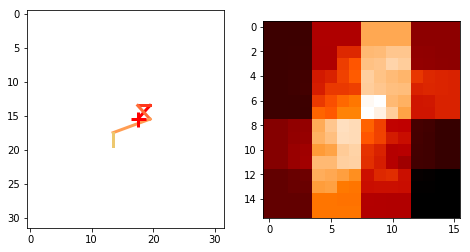

In [60]:
affiche_path_H(H_generic)

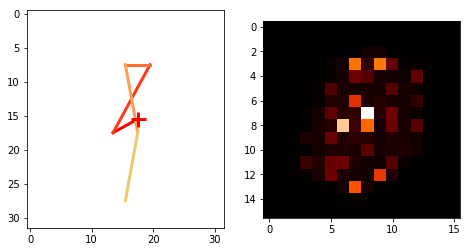

In [61]:
affiche_path_H(H_generic_eff)